In [ ]:
# Mount drive
import os
from google.colab import drive
drive.mount('/gdrive')

root = '/gdrive/My Drive/KAIST/CS454 AI-Based SE/Code'


Mounted at /gdrive


In [ ]:
from PIL import Image
from tqdm import tqdm
from pathlib import Path
import time
import matplotlib.pyplot as plt

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.datasets import MNIST, ImageFolder
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from google.colab.patches import cv2_imshow

model = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True)

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


In [ ]:
# Set hyperparameters
from easydict import EasyDict as edict

torch.manual_seed(470)
torch.cuda.manual_seed(470)

args = edict()

# basic options 
args.name = 'main'                   # experiment name.
args.ckpt_dir = 'ckpts'              # checkpoint directory name.
args.ckpt_iter = 10000               # how frequently checkpoints are saved.
args.ckpt_reload = 'best'            # which checkpoint to re-load.
args.gpu = True                      # whether or not to use gpu. 

# data options
args.dataroot = 'dataset/mnist'    # where CIFAR10 images exist.
args.batch_size = 128                # number of mini-batch size.

# training options
args.lr = 0.01                        # learning rate.
args.epoch = 15                     # training epoch.

In [ ]:
result_dir = Path(root) / 'results_mnist'
result_dir.mkdir(parents=True, exist_ok=True)

device = 'cuda' if torch.cuda.is_available() and args.gpu else 'cpu' # move the input and model to GPU for speed if available
model = model.to(device)

In [ ]:
# sample execution (requires torchvision)
import torchvision
train_transform = transforms.Compose([
      torchvision.transforms.ToTensor(),
      torchvision.transforms.Normalize(
        (0.1307,), (0.3081,))
    ])

test_transform = transforms.Compose([
      torchvision.transforms.ToTensor(),
      torchvision.transforms.Normalize(
        (0.1307,), (0.3081,))
    ])

train_dataset = MNIST(args.dataroot, download=True, train=True, transform=train_transform)
test_dataset = MNIST(args.dataroot, download=True, train=False, transform=test_transform)

train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False, drop_last=False)

Extracting dataset/mnist/MNIST/raw/train-images-idx3-ubyte.gz to dataset/mnist/MNIST/raw


Extracting dataset/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/mnist/MNIST/raw


Extracting dataset/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/mnist/MNIST/raw




Extracting dataset/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/mnist/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
!ls dataset/mnist/MNIST/raw

t10k-images-idx3-ubyte	   train-images-idx3-ubyte
t10k-images-idx3-ubyte.gz  train-images-idx3-ubyte.gz
t10k-labels-idx1-ubyte	   train-labels-idx1-ubyte
t10k-labels-idx1-ubyte.gz  train-labels-idx1-ubyte.gz


In [ ]:
def test_model(model, optimizer):
    global_step = 0
    best_accuracy = 0.

    for epoch in range(args.epoch):
        # Here starts the train loop.
        model.train()
        for batch_idx, (x, y) in enumerate(train_dataloader):

            global_step += 1

            #  Send `x` and `y` to either cpu or gpu using `device` variable. 
            x = x.to(device)
            y = y.to(device)
            
            # Feed `x` into the network, get an output, and keep it in a variable called `logit`. 
            logit = model(x)

            # Compute accuracy of this batch using `logit`, and keep it in a variable called 'accuracy'.
            accuracy = (logit.argmax(1) == y).float().mean()

            # print(logit)
            # print(y)
            # Compute loss using `logit` and `y`, and keep it in a variable called `loss`.
            loss = nn.CrossEntropyLoss()(logit, y)

            # flush out the previously computed gradient.
            optimizer.zero_grad()

            # backward the computed loss. 
            loss.backward()

            # update the network weights. 
            optimizer.step()

            if global_step % args.ckpt_iter == 0: 
                # Save network weights in the directory specified by `ckpt_dir` directory. 
                torch.save(model.state_dict(), f'{result_dir}/{global_step}.pt')

        # Here starts the test loop.
        model.eval()
        with torch.no_grad():
            test_loss = 0.
            test_accuracy = 0.
            test_num_data = 0.
            for batch_idx, (x, y) in enumerate(test_dataloader):
                # Send `x` and `y` to either cpu or gpu using `device` variable..
                x = x.to(device)
                y = y.to(device)

                # Feed `x` into the network, get an output, and keep it in a variable called `logit`.
                logit = model(x)

                # Compute loss using `logit` and `y`, and keep it in a variable called `loss`.
                loss = nn.CrossEntropyLoss()(logit, y)

                # Compute accuracy of this batch using `logit`, and keep it in a variable called 'accuracy'.
                accuracy = (logit.argmax(dim=1) == y).float().mean()

                test_loss += loss.item()*x.shape[0]
                test_accuracy += accuracy.item()*x.shape[0]
                test_num_data += x.shape[0]

            test_loss /= test_num_data
            test_accuracy /= test_num_data

            # Just for checking progress
            print(f'Test result of epoch {epoch}/{args.epoch} || loss : {test_loss:.3f} acc : {test_accuracy:.3f} ')

            # Whenever `test_accuracy` is greater than `best_accuracy`, save network weights with the filename 'best.pt' in the directory specified by `ckpt_dir`.
            if test_accuracy > best_accuracy:
                best_accuracy = test_accuracy
                torch.save(model.state_dict(), f'{result_dir}/best.pt')
    
        # scheduler.step()
    return best_accuracy

In [ ]:
#Updating the second classifier
model.features[0] = nn.Conv2d(1, 64, (4, 4), stride=(2,2), padding=(2, 2))
model.classifier[4] = nn.Linear(4096,1024)

#Updating the third and the last classifier that is the output layer of the network. Make sure to have 10 output nodes if we are going to get 10 class labels through our model.
model.classifier[6] = nn.Linear(1024,10)
model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
   

In [ ]:
# Load the trained model using CIFAR
model = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet')
#Updating the second classifier
model.features[0] = nn.Conv2d(1, 64, (4, 4), stride=(2,2), padding=(2, 2))
model.classifier[4] = nn.Linear(4096,1024)

#Updating the third and the last classifier that is the output layer of the network. Make sure to have 10 output nodes if we are going to get 10 class labels through our model.
model.classifier[6] = nn.Linear(1024,10)
model.load_state_dict(torch.load("../gdrive/MyDrive/CS454_AI-Based_SE/Code/results_mnist/best.pt", torch.device('cpu') ))
model.eval()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


AlexNet(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
   

In [ ]:
!ls ../gdrive/MyDrive/CS454_AI-Based_SE/Code/results_mnist/best.pt

../gdrive/MyDrive/CS454_AI-Based_SE/Code/results_mnist/best.pt


In [ ]:
import pandas as pd
final_test = pd.read_csv("../gdrive/MyDrive/CS454_AI-Based_SE/Code/sample_image/test.csv", dtype=np.float32)
final_test = final_test.values/255
test_tn = torch.from_numpy(final_test)

tensor([5])


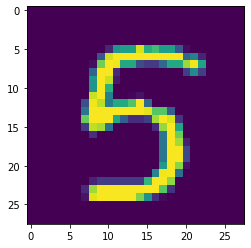

In [ ]:
import random
sample_test = test_tn[random.randint(0, len(test_tn))].view(28, 28)
output = model(sample_test.unsqueeze(0).unsqueeze(1))
true_class = output.argmax(1)
print(true_class)
plt.imshow(  sample_test  )

In [ ]:
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: dataset/mnist
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


128
tensor([7, 2, 1, 0, 4, 1, 4, 9])


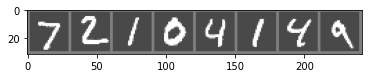


tensor([7, 2, 1, 0, 4, 1, 4, 9])


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision


# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(test_dataloader)
images, labels = dataiter.next()

print(len(images))
print(labels[:8])

# show images
imshow(torchvision.utils.make_grid(images[:8]))
# print labels


logit = model(images)
#print(logit)
print()
sol = torch.max(logit[:8] ,1).indices
print(sol)


In [ ]:
images.shape

torch.Size([128, 1, 28, 28])

In [ ]:
model(images).shape

torch.Size([128, 10])

tensor([9])


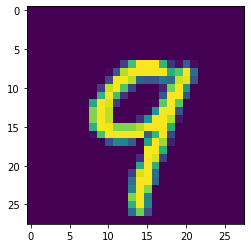

In [ ]:
import random
sample_test = images[12].view(28, 28)
output = model(sample_test.unsqueeze(0).unsqueeze(1))
true_class = output.argmax(1)
print(true_class)
plt.imshow(  sample_test  )

In [ ]:
(labels == 9).nonzero()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  """Entry point for launching an IPython kernel.


tensor([[  7],
        [  9],
        [ 12],
        [ 16],
        [ 20],
        [ 58],
        [ 62],
        [ 73],
        [ 78],
        [ 92],
        [ 99],
        [104],
        [105],
        [108],
        [113],
        [118],
        [125]])

In [ ]:
# made the reference image
ref_image = [images[10].view(28, 28),#0
             images[2].view(28, 28), #1
             images[1].view(28, 28), #2
             images[30].view(28, 28), #3
             images[19].view(28, 28), #4
             images[23].view(28, 28), #5
             images[21].view(28, 28), #6
             images[0].view(28, 28),  #7
             images[84].view(28, 28), #8
             images[12].view(28, 28) #9
             ]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


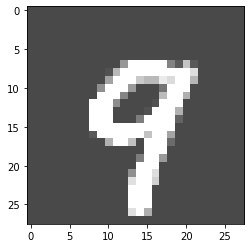

In [ ]:
imshow(torchvision.utils.make_grid(ref_image[9]))


In [ ]:
ref_image[0]

tensor([[-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242

In [ ]:
images.shape

torch.Size([128, 1, 28, 28])

In [ ]:
images[0,:,:].shape

torch.Size([1, 28, 28])

In [ ]:
logit.shape

torch.Size([128, 10])

In [ ]:
logit[:8]

tensor([[-2.9528, -0.5697,  0.2101,  0.9952, -1.7708, -2.8707, -6.1776, 14.1636,
         -2.2665,  1.6344],
        [-1.9909, -0.8380, 14.7656, -1.2869, -0.5951, -4.1845, -0.2987, -2.0652,
         -1.2570, -4.9518],
        [-2.6480, 13.3275, -2.4334, -4.2272, -1.9936, -2.7064, -2.1455,  2.1899,
         -0.0313, -1.4974],
        [11.8924, -3.2745, -2.2165, -3.3335, -2.7864, -0.9102,  1.6091, -2.3073,
         -0.5503, -0.6999],
        [-4.4874, -2.0676, -3.3821, -7.7852, 16.0683, -2.1576,  0.2212, -1.0209,
         -0.6734,  3.4905],
        [-2.8754, 14.4885, -2.8850, -4.5884, -1.9679, -2.8656, -2.4827,  2.0482,
         -0.0799, -1.3385],
        [-4.1344, -2.5256, -2.9367, -5.9214, 13.4922, -1.8114, -0.2187, -1.5272,
          0.6264,  3.6247],
        [-2.0302, -3.8040, -1.0236,  1.1557,  1.1335,  0.8364, -3.2060, -0.5924,
          0.7834,  6.9800]], grad_fn=<SliceBackward>)

In [ ]:
 torch.max(logit[:8] ,1).indices

tensor([7, 2, 1, 0, 4, 1, 4, 9])

In [ ]:
img_1 = images[0,:1,:2,:2]
img_2 = images[1,:1,:2,:2]

In [ ]:
print(img_1)
print(img_2)
print(img_1 - img_2)

tensor([[[-0.4242, -0.4242],
         [-0.4242, -0.4242]]])
tensor([[[-0.4242, -0.4242],
         [-0.4242, -0.4242]]])
tensor([[[0., 0.],
         [0., 0.]]])


In [ ]:
torch.norm(img_1 - img_2, 2)

tensor(0.)

In [ ]:
images.shape

torch.Size([128, 1, 28, 28])

In [ ]:
# base model 


In [ ]:
import torch
import random, copy


def scoreCalculate(model,x, x_label):
  ImX = x.unsqueeze(0)
  result = torch.max(model(ImX),1)
  confidence = result.values
  index = result.indices
  if index == x_label:
    score = confidence
  else:
    score = 0
  return score

def ftnCalculate(model,x,y,y_label):
  ImY = y.unsqueeze(0)
  result = torch.max(model(ImY),1)
  confidence = result.values
  index = result.indices
  if index == y_label:
    score = confidence
  else:
    score = 0
  L2 = torch.cdist(x, y, p=2)
  return score - L2 

def targetPSO(model,x,x_label, D, N, V, Beta, Epsilon, Zeta):
  print('x', x.shape)
  # initialize

  pixelsX = (pixelsX-torch.min(pixelsX))/(torch.max(pixelsX)-torch.min(pixelsX))
  pixelsY = (pixelsY-torch.min(pixelsY))/(torch.max(pixelsY)-torch.min(pixelsY))
  S= torch.clip(torch.rand(N,3,h,w)+pixelsY,0.0,1.0)
  ftn = torch.zeros(N, dtype=float)
  for i in range(N):
    ftn[i] = ftnCalculate(model,pixelsX,S[i],y_label)
  Pbest = pixelsY.clone()
  Pbestftn = ftn.clone()
  Gbest = Pbest[0].clone()
  Gbestftn = ftn[0]
  pv = torch.zeros(N,3,h,w)
  for p in range(V/N):
    score_array = torch.zeros(N)
    for i in range(N):
      score_array[i] = scoreCalculate(model,pixelsY, y_label)
    mean_score = torch.mean(score_array)
    if mean_score < score_limit:
      pv =pv + random.rand()*(Pbest-S) + random.rand()*(Gbest-S) + (pixelsX-S) + torch.rand(N,3,h,w)
      #pv =c1*pv + c2*random.rand()*(Pbest-S) + c3*random.rand()*(Gbest-S) + c4*(pixelsX-S) + c5*torch.rand(N,3,h,w)
    else:
      pv = pv + random.rand()*(Gbest-S) + (pixelsX-S) + torch.rand(N,3,h,w)
      #pv = c1* pv + c3*random.rand()*(Gbest-S) + c4*(pixelsX-S) + c5*torch.rand(N,3,h,w)
    S = torch.clip(S+pv, 0.0, 1.0)
    for i in range(N):
      ftn[i] = ftnCalculate(model,pixelsX,S[i],y_label)
    if ftn[i] > Pbest[i]:
      Pbest[i] = copy.deepcopy(ftn[i])
      Pbestftn[i] = ftn[i]
      if Pbestftn[i] > Gbestftn:
        Gbest = copy.deepcopy(Pbest[i])
        Gbestftn = Pbestftn[i]
  if torch.cdist(Gbest, pixelsX, p=2) <= upper_bound_distance and scoreCalculate(model,Gbest,y_label) >= lower_bound_score:
    return Image.fromarray(Gbest)
  else:
    return Image.fromarray(Gbest), torch.cdist(Gbest, pixelsX, p=2), scoreCalculate(model,Gbest,y_label)

In [ ]:
# PSO
def similarity(img_1, img_2, p):
  return torch.norm(img_1 - img_2, p)

def check_top(out_s, label):
  #print(label.item())
  #print(torch.topk(out_s, 1))
  top_index = torch.topk(out_s, 1).indices
  if torch.sum(label.item() == top_index).item() == 1:
    # contain in top 1
    return 1
  return 0

def cal_score(out_s, label):
  # out_s: (10)

  if check_top(out_s, label):
    # in top 1
    return 0
  else:
    # they are not in top1
    #print('value',out_s[label.item()].item())
    #print('lable',label)
    #print(out_s)
    #print(torch.topk(out_s, 1))
    score = out_s[torch.topk(out_s, 1).indices].item()
    #print('score', score)
    
    return score

def cal_ftn(model,input_s,org_img, label, sigma, Epsilon):
  # get the classification from the model
  # org_img: (1, 1, 28, 28)
  # input_s: (N, 1, 28, 28)
  global count_model
  count_model += 1
  output_s = model(input_s) # (N, 10)
  N, num_c = output_s.shape
  ftn_list = []
  for i in range(N):

    # calculate score
    score = cal_score( output_s[i], label)
    # calculate L_2
    L_2 = similarity(org_img, input_s[i].view(1,1,28,28), 2)
    #print(L_2)
    if L_2 > Epsilon:
      L_2 = 100

    #print("Score", score ,'L_2',L_2)
    ftn = sigma * score - L_2
    #print("ftn", ftn)
    #print()
    ftn_list.append(ftn)
  ftn_torch = torch.Tensor(ftn_list)
  #print("ftn_torch", ftn_torch)
  #print()
  return ftn_torch

def get_global(p_best_ftn, S):
  G_best_ftn, index = torch.topk(p_best_ftn,1)
  #print("G_best_ftn",G_best_ftn, index)
  G_best =  S[index] # (1,1,28,28)
  #print(G_best.shape)
  return G_best, G_best_ftn


def calculate_v(V, S, p_best, G_best, N):
  w = 1
  c1 = 1
  c2 = 1
  G_best_new = G_best.squeeze(0).repeat(N,1,1,1)
  V_next = (w * V) + (c1 * torch.rand(N, 1, 28, 28)*(p_best - S)) + (c2 * torch.rand(N, 1, 28, 28)*(G_best_new - S) )
  
  return V_next

def get_personal_best(S, S_score, p_best, p_best_ftn ):
  # S: N, 1, 28, 28 (N =20)
  # S_score: N
  # p_best: N, 1, 28, 28
  # p_best_ftn: N
  
  index = S_score > p_best_ftn

  p_best_ftn[index] = S_score[index]
  p_best[index] = S[index]

  return p_best, p_best_ftn
  

def targetPSO(model,x,x_label, D, N, V, Beta, Epsilon, Zeta, sigma):
  G_list = []
  for i_x in range(len(x)):
    cur_x = x[i_x].view(1,1,28,28)
    cur_label = x_label[i_x]
    # initialize V
    V = torch.zeros(N,1,28,28)

    #initialize the population of N particle
    S = torch.clip(cur_x + torch.rand(N,1,28,28),-0.4242,2.8215) # (N,1,28,28)
    
    # calculate the score for each particles
    S_score = cal_ftn(model,S ,cur_x, cur_label, sigma, Epsilon) # (N)
    #print("S_score",S_score)

    p_best = S # keep the particle value that best (N,1,28,28)
    p_best_ftn = S_score # keep the fitness function (N)
    # get Global
    G_best, G_best_ftn = get_global(p_best_ftn, S) #G_best (1,1,28,28), G_best_ftn (1)
    
    for i in range(1000):
      V = calculate_v(V, S, p_best, G_best, N)
      
      # update S and S_score
      S = torch.clip(S + V ,-0.4242,2.8215)#(N,1,28,28)
      S_score = cal_ftn(model,S ,cur_x, cur_label, sigma, Epsilon)
      
      # get_personal best
      p_best, p_best_ftn = get_personal_best(S, S_score, p_best, p_best_ftn)
      G_best, G_best_ftn = get_global(p_best_ftn, S)
      
    G_list.append(G_best)
    imshow(torchvision.utils.make_grid(G_best))
    print(torch.topk(model(G_best),1))
  result = torch.cat(G_list, dim=0)
  return result


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


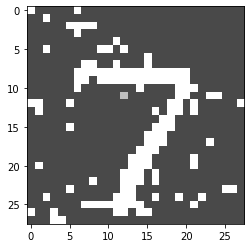

torch.return_types.topk(
values=tensor([[14.5390]], grad_fn=<TopkBackward>),
indices=tensor([[2]]))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


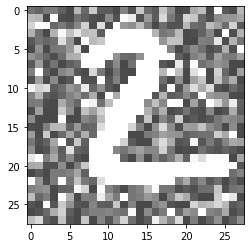

torch.return_types.topk(
values=tensor([[13.4798]], grad_fn=<TopkBackward>),
indices=tensor([[2]]))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


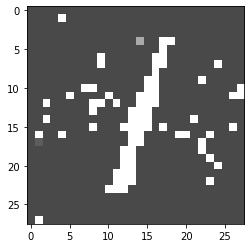

torch.return_types.topk(
values=tensor([[21.0668]], grad_fn=<TopkBackward>),
indices=tensor([[4]]))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


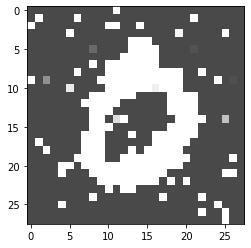

torch.return_types.topk(
values=tensor([[13.2333]], grad_fn=<TopkBackward>),
indices=tensor([[2]]))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


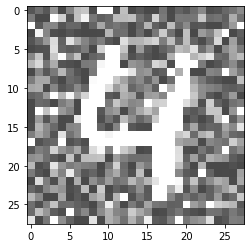

torch.return_types.topk(
values=tensor([[13.0266]], grad_fn=<TopkBackward>),
indices=tensor([[4]]))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


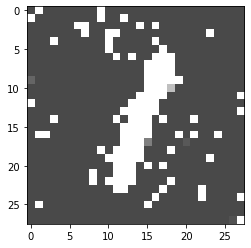

torch.return_types.topk(
values=tensor([[17.3155]], grad_fn=<TopkBackward>),
indices=tensor([[2]]))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


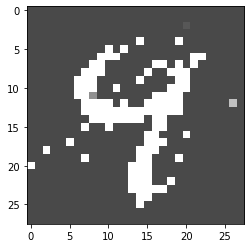

torch.return_types.topk(
values=tensor([[10.8076]], grad_fn=<TopkBackward>),
indices=tensor([[9]]))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


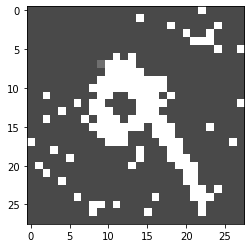

torch.return_types.topk(
values=tensor([[15.5088]], grad_fn=<TopkBackward>),
indices=tensor([[5]]))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


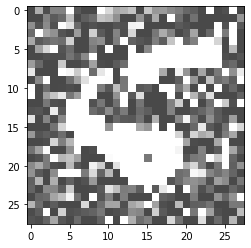

torch.return_types.topk(
values=tensor([[3.7451]], grad_fn=<TopkBackward>),
indices=tensor([[5]]))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


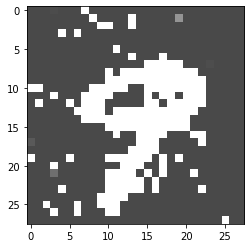

torch.return_types.topk(
values=tensor([[17.0063]], grad_fn=<TopkBackward>),
indices=tensor([[3]]))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


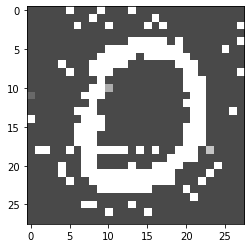

torch.return_types.topk(
values=tensor([[16.1298]], grad_fn=<TopkBackward>),
indices=tensor([[2]]))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


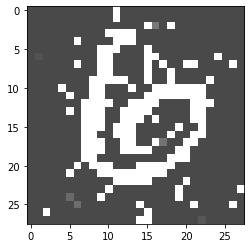

torch.return_types.topk(
values=tensor([[12.9298]], grad_fn=<TopkBackward>),
indices=tensor([[8]]))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


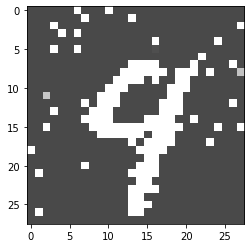

torch.return_types.topk(
values=tensor([[19.8906]], grad_fn=<TopkBackward>),
indices=tensor([[4]]))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


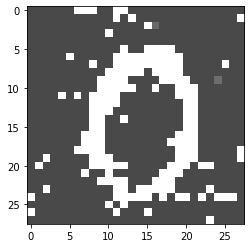

torch.return_types.topk(
values=tensor([[14.1170]], grad_fn=<TopkBackward>),
indices=tensor([[2]]))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


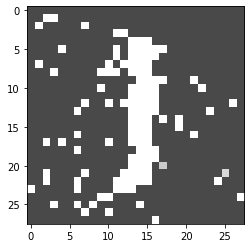

torch.return_types.topk(
values=tensor([[17.0250]], grad_fn=<TopkBackward>),
indices=tensor([[3]]))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


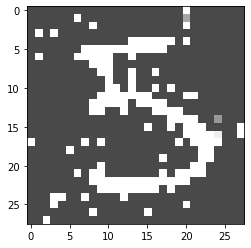

torch.return_types.topk(
values=tensor([[17.0742]], grad_fn=<TopkBackward>),
indices=tensor([[3]]))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


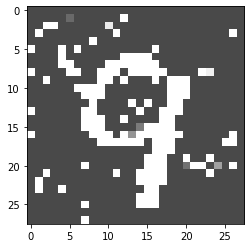

torch.return_types.topk(
values=tensor([[11.2875]], grad_fn=<TopkBackward>),
indices=tensor([[7]]))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


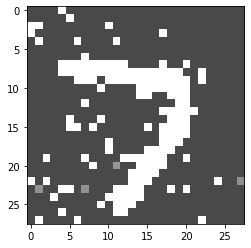

torch.return_types.topk(
values=tensor([[17.9777]], grad_fn=<TopkBackward>),
indices=tensor([[3]]))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


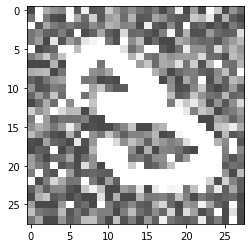

torch.return_types.topk(
values=tensor([[6.0462]], grad_fn=<TopkBackward>),
indices=tensor([[3]]))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


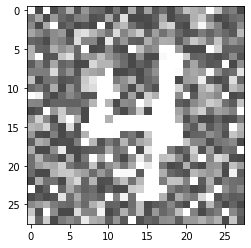

torch.return_types.topk(
values=tensor([[15.0476]], grad_fn=<TopkBackward>),
indices=tensor([[4]]))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


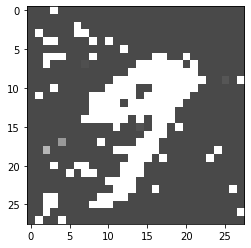

torch.return_types.topk(
values=tensor([[18.5614]], grad_fn=<TopkBackward>),
indices=tensor([[3]]))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


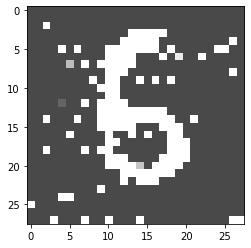

torch.return_types.topk(
values=tensor([[16.2289]], grad_fn=<TopkBackward>),
indices=tensor([[5]]))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


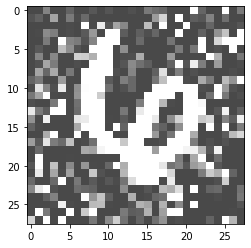

torch.return_types.topk(
values=tensor([[10.3239]], grad_fn=<TopkBackward>),
indices=tensor([[4]]))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


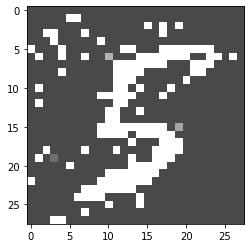

torch.return_types.topk(
values=tensor([[17.7454]], grad_fn=<TopkBackward>),
indices=tensor([[3]]))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


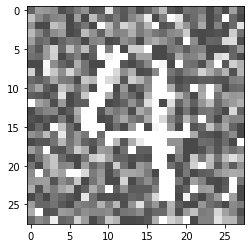

torch.return_types.topk(
values=tensor([[14.3951]], grad_fn=<TopkBackward>),
indices=tensor([[4]]))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


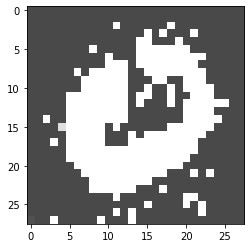

torch.return_types.topk(
values=tensor([[11.3232]], grad_fn=<TopkBackward>),
indices=tensor([[8]]))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


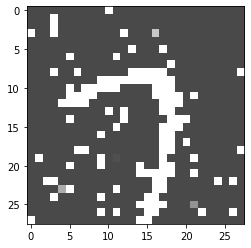

torch.return_types.topk(
values=tensor([[16.8762]], grad_fn=<TopkBackward>),
indices=tensor([[3]]))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


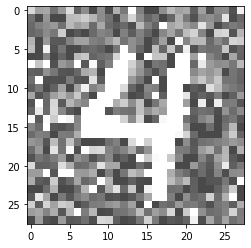

torch.return_types.topk(
values=tensor([[14.8410]], grad_fn=<TopkBackward>),
indices=tensor([[4]]))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


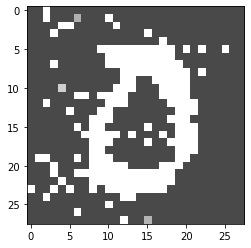

torch.return_types.topk(
values=tensor([[15.4636]], grad_fn=<TopkBackward>),
indices=tensor([[3]]))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


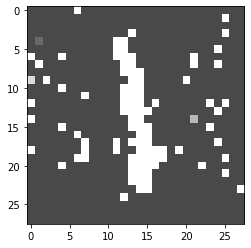

torch.return_types.topk(
values=tensor([[14.8506]], grad_fn=<TopkBackward>),
indices=tensor([[4]]))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


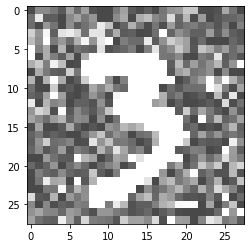

torch.return_types.topk(
values=tensor([[13.9342]], grad_fn=<TopkBackward>),
indices=tensor([[3]]))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


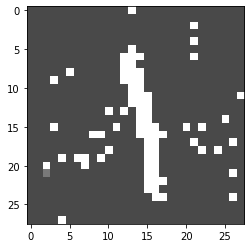

torch.return_types.topk(
values=tensor([[16.2128]], grad_fn=<TopkBackward>),
indices=tensor([[4]]))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


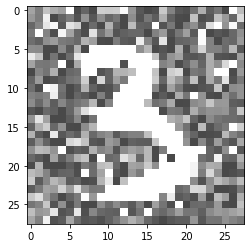

torch.return_types.topk(
values=tensor([[13.8315]], grad_fn=<TopkBackward>),
indices=tensor([[3]]))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


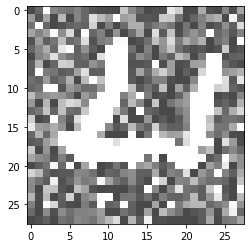

torch.return_types.topk(
values=tensor([[13.9539]], grad_fn=<TopkBackward>),
indices=tensor([[4]]))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


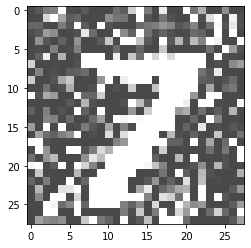

torch.return_types.topk(
values=tensor([[6.7255]], grad_fn=<TopkBackward>),
indices=tensor([[2]]))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


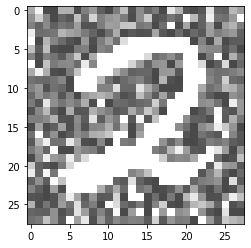

torch.return_types.topk(
values=tensor([[15.4473]], grad_fn=<TopkBackward>),
indices=tensor([[2]]))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


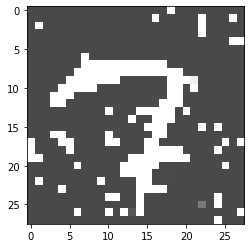

torch.return_types.topk(
values=tensor([[12.3628]], grad_fn=<TopkBackward>),
indices=tensor([[5]]))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


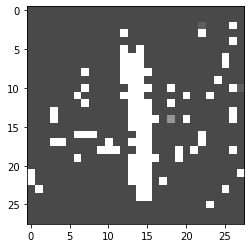

torch.return_types.topk(
values=tensor([[19.0644]], grad_fn=<TopkBackward>),
indices=tensor([[4]]))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


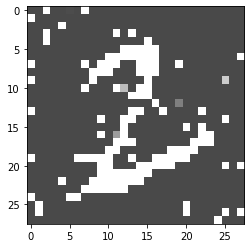

torch.return_types.topk(
values=tensor([[18.6525]], grad_fn=<TopkBackward>),
indices=tensor([[3]]))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


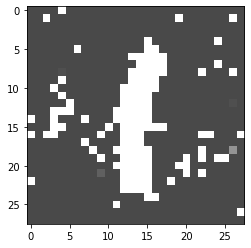

torch.return_types.topk(
values=tensor([[17.6841]], grad_fn=<TopkBackward>),
indices=tensor([[4]]))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


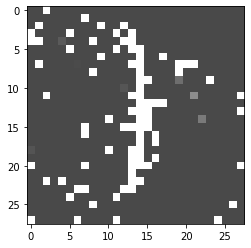

torch.return_types.topk(
values=tensor([[18.7355]], grad_fn=<TopkBackward>),
indices=tensor([[3]]))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


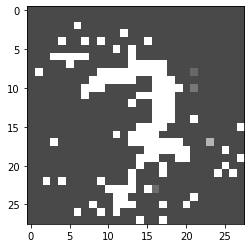

torch.return_types.topk(
values=tensor([[19.5958]], grad_fn=<TopkBackward>),
indices=tensor([[3]]))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


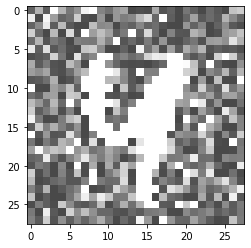

torch.return_types.topk(
values=tensor([[12.5334]], grad_fn=<TopkBackward>),
indices=tensor([[4]]))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


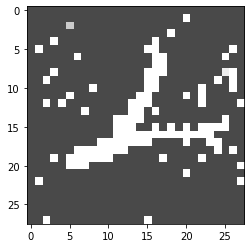

torch.return_types.topk(
values=tensor([[19.6201]], grad_fn=<TopkBackward>),
indices=tensor([[4]]))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


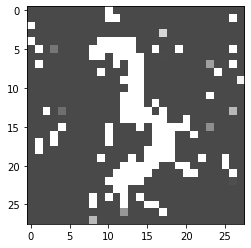

torch.return_types.topk(
values=tensor([[15.5371]], grad_fn=<TopkBackward>),
indices=tensor([[2]]))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


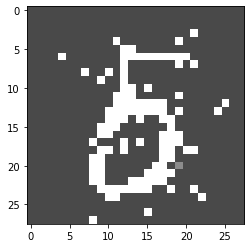

torch.return_types.topk(
values=tensor([[13.9106]], grad_fn=<TopkBackward>),
indices=tensor([[8]]))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


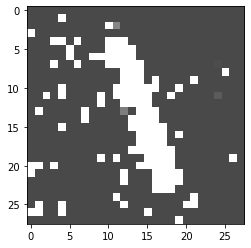

torch.return_types.topk(
values=tensor([[16.3520]], grad_fn=<TopkBackward>),
indices=tensor([[3]]))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


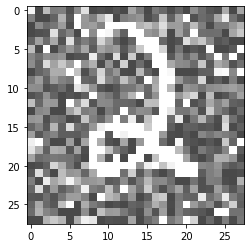

torch.return_types.topk(
values=tensor([[14.0516]], grad_fn=<TopkBackward>),
indices=tensor([[2]]))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


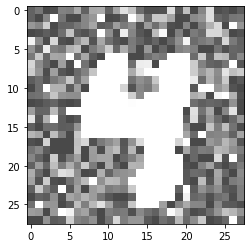

torch.return_types.topk(
values=tensor([[8.8957]], grad_fn=<TopkBackward>),
indices=tensor([[4]]))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


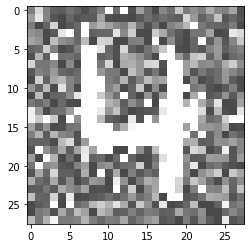

torch.return_types.topk(
values=tensor([[11.6178]], grad_fn=<TopkBackward>),
indices=tensor([[4]]))


In [ ]:
count_model = 0
import time

start = time.time()
G_list = targetPSO(model, 
          images[:50], 
          labels, # y* target 
          D = 0,
          N = 24, #N: swan size
          V = 100, # V: number of query
          Epsilon = 25, #epsilon (upper_bound_distance): 
          Zeta = 1, # zeta (score_limit)
          Beta = 1, # beta : lower confidence limit against the adversarial example.
          sigma = 1.9
)
end = time.time()


In [ ]:
print((end - start)/50)

100.39175817012787


In [ ]:
count_model/ 50

1001.0

In [ ]:
G_list.shape

torch.Size([50, 1, 28, 28])

In [ ]:
torch.save(G_list, '../gdrive/MyDrive/CS454_AI-Based_SE/Code/pso_result.pt')

In [ ]:
G_list = torch.load('../gdrive/MyDrive/CS454_AI-Based_SE/Code/pso_result.pt')

In [ ]:
G_list[0]

torch.Size([1, 28, 28])

In [ ]:
count = 0
for i in range(50):
  
  result = torch.topk(model(G_list[i].view(1,1,28,28)),1).indices.item()
  #print(result)
  if result != labels[i]:
    count += 1
print(count)

35


In [ ]:
labels[0]

tensor(7)

In [ ]:
G_list.shape

torch.Size([5, 1, 28, 28])

In [ ]:
G_value = []

In [ ]:
!ls ../gdrive/MyDrive/CS454_AI-Based_SE/Code/

 alexnet_pytorch_vision.ipynb	       results
 Chi_test.ipynb			       results2
'Copy of DeepSearchTestEdited.ipynb'   results3
'Copy of Genetic Test.ipynb'	       results_mnist
 DeepSearchTestEdited.ipynb	       sample_image
'Genetic Test.ipynb'		       Untitled0.ipynb
 PSO_unfinished.ipynb		      '(version2) alexnet_pytorch_vision.ipynb'


In [ ]:
print(G_best.shape)

torch.Size([1, 1, 28, 28])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


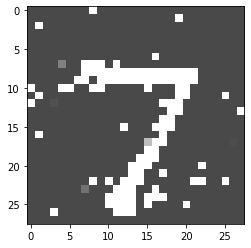

In [ ]:
imshow(torchvision.utils.make_grid(G_best))


In [ ]:
torch.topk(model(images[4].view(1,1,28,28)),1)

torch.return_types.topk(values=tensor([[16.0683]], grad_fn=<TopkBackward>), indices=tensor([[4]]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


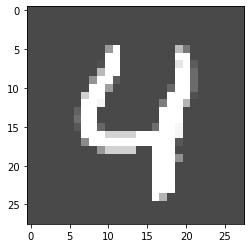

In [ ]:
imshow(torchvision.utils.make_grid(images[4]))

In [ ]:
print(images[:20].shape)
print(labels.shape)

torch.Size([20, 1, 28, 28])
torch.Size([128])


In [ ]:
labels

tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6, 7, 0, 4, 9,
        5, 2, 4, 0, 9, 6, 6, 5, 4, 5, 9, 2, 4, 1, 9, 5, 4, 6, 5, 6, 0, 9, 3, 9,
        7, 6, 9, 8, 0, 3, 8, 8, 7, 7, 4, 6, 7, 3, 6, 3, 6, 2, 1, 2, 3, 7, 2, 6,
        8, 8, 0, 2, 9, 3, 3, 8, 8, 1, 1, 7, 2, 5, 2, 7, 8, 9, 0, 3, 8, 6, 4, 6,
        6, 0, 0, 7, 4, 5, 6, 3, 1, 1, 3, 6, 8, 7, 4, 0, 6, 2, 1, 3, 0, 4, 2, 7,
        8, 3, 1, 2, 8, 0, 8, 3])

In [ ]:
images[0]

tensor([[[-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0

In [ ]:
torch.rand(4) 

tensor([0.7345, 1.3944, 0.8477, 1.1810])